In [1]:
import os
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, split_forecasts_by_week, \
forecast_by_week, train_test_split
from PythonFiles.PlottingFunctions import plot_coverage, print_forecasts_by_week, hyperparameter_boxplots, plot_model_results_by_hp, hp_color_plot
from PythonFiles.Configuration import Configuration
from PythonFiles.HpTuning import get_data, restore_HP_results, objectiveFNN, generate_model_results_by_hp_dict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from ray import tune
configuration = Configuration()

In [2]:
#experiment_path = "/home/reffert/ray_results/objectiveFNN_2023-05-27_09-47-44"
#df = restore_HP_results(experiment_path, objectiveFNN, train, test, configuration)
df1 = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/HyperparameterFiles/FNN_Hyperparameter_results_31_05.csv", sep=',')
df2 = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/HyperparameterFiles/FNN_Hyperparameter_results_31_05_02.csv", sep=',')
hp_search_space1 = {
    "num_hidden_dimensions": tune.grid_search([[140,140],[180,180]]),
    "context_length":tune.grid_search([2, 26, 208]),
    "epochs":tune.grid_search([100, 200]),
    "prediction_length" : tune.grid_search([4]), 
    "num_batches_per_epoch":tune.grid_search([40, 60]),
    "batch_normalization":tune.grid_search([True, False]),
    "batch_size":tune.grid_search([16, 64]),
    }

hp_search_space2 = {
    "num_hidden_dimensions": tune.grid_search([[140,140],[180,180]]),
    "context_length":tune.grid_search([1, 2, 4, 104, 208]),
    "epochs":tune.grid_search([50, 75, 150]),
    "prediction_length" : tune.grid_search([4]), 
    "num_batches_per_epoch":tune.grid_search([20, 120]),
    "batch_normalization":tune.grid_search([True, False]),
    "batch_size":tune.grid_search([8, 124]),
    }

if "config/num_hidden_dimensions"in list(df1.columns):
    df1["config/num_hidden_dimensions"]=df1["config/num_hidden_dimensions"].apply(tuple)

if "config/num_hidden_dimensions"in list(df2.columns):
    df2["config/num_hidden_dimensions"]=df2["config/num_hidden_dimensions"].apply(tuple)
#df = df.loc[df["config/prediction_length"]==4]

In [3]:
model_results_by_hp1, overall_df1 = generate_model_results_by_hp_dict(df1, hp_search_space1)
model_results_by_hp2, overall_df2 = generate_model_results_by_hp_dict(df2, hp_search_space2)

                           total_modelruns  independent_combinations
modelruns_per_combination                                           
5.0                                    480                      96.0
                           total_modelruns  independent_combinations
modelruns_per_combination                                           
5.0                                   1200                     240.0


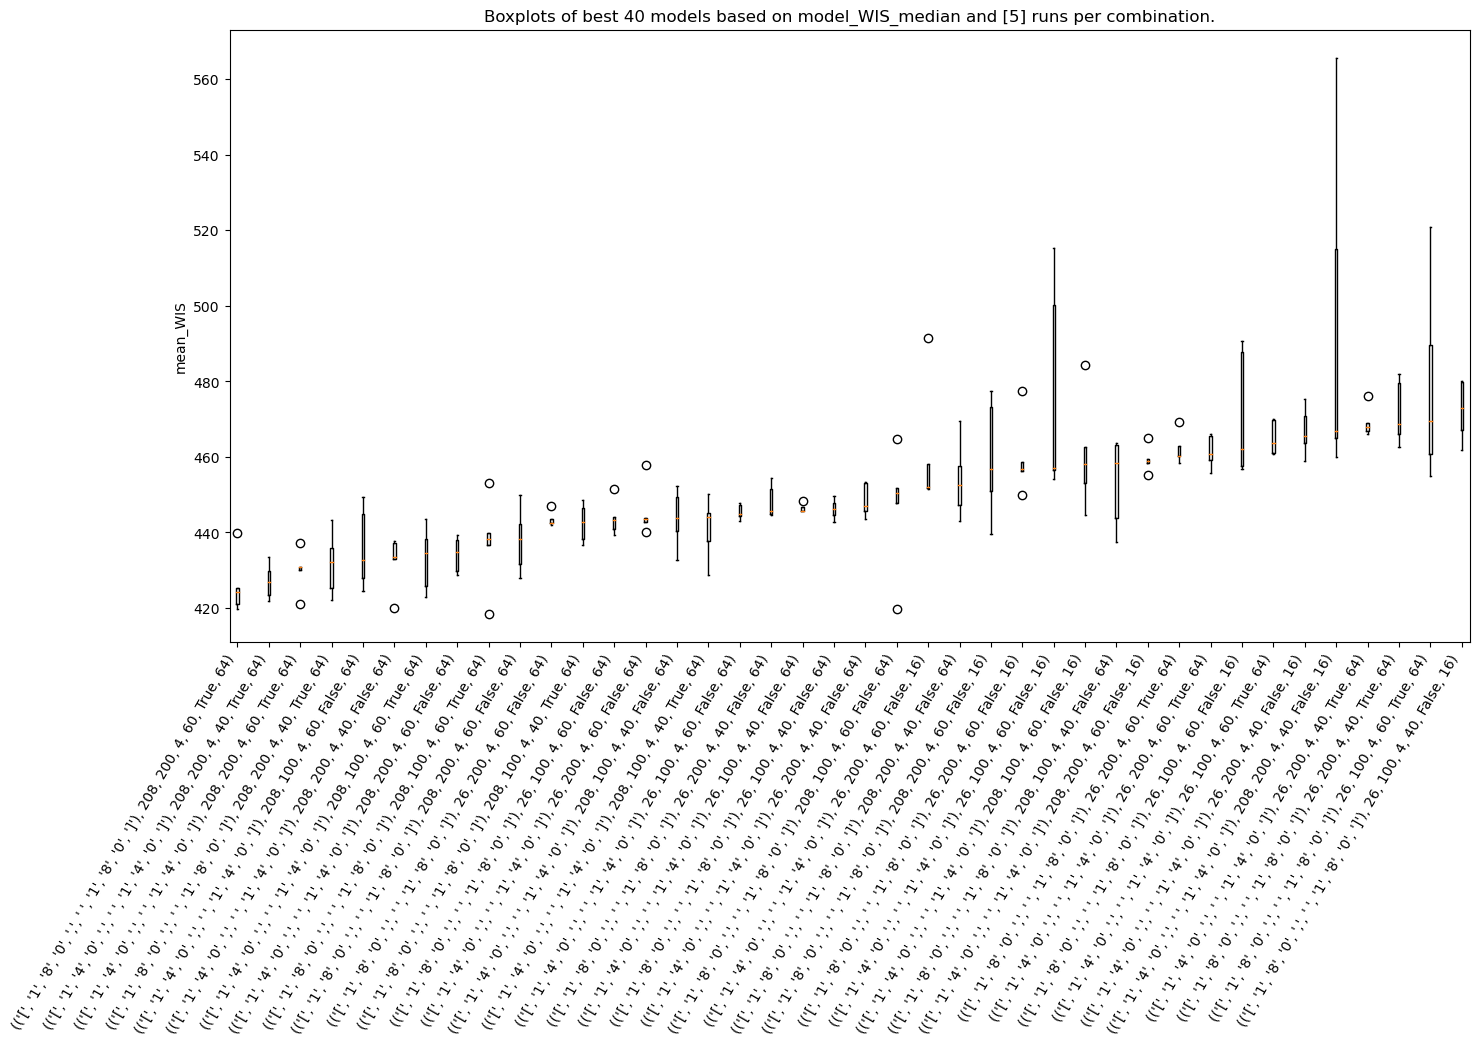

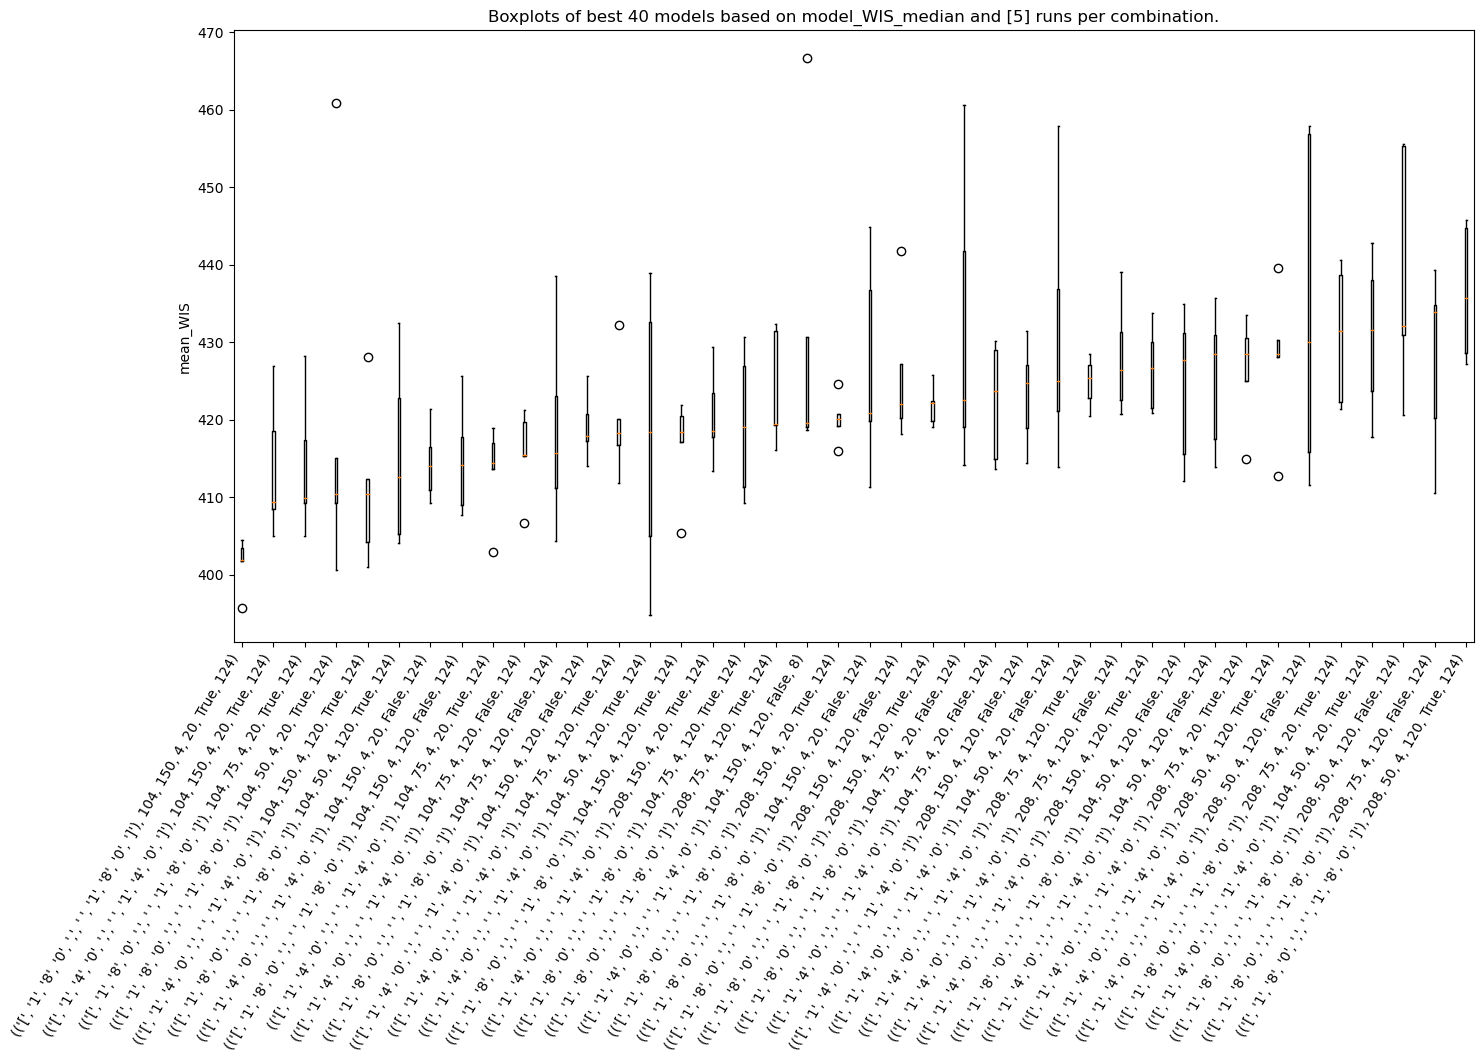

In [4]:

plot_model_results_by_hp(configuration, model_results_by_hp1, hp_search_space1, number_of_plots=40, col="mean_WIS",figsize=(16, 9), overall_df=overall_df1, sort_by="model_WIS_median", plottype="best", plot = "bp")
plot_model_results_by_hp(configuration, model_results_by_hp2, hp_search_space2, number_of_plots=40, col="mean_WIS",figsize=(16, 9), overall_df=overall_df2, sort_by="model_WIS_median", plottype="best", plot = "bp")

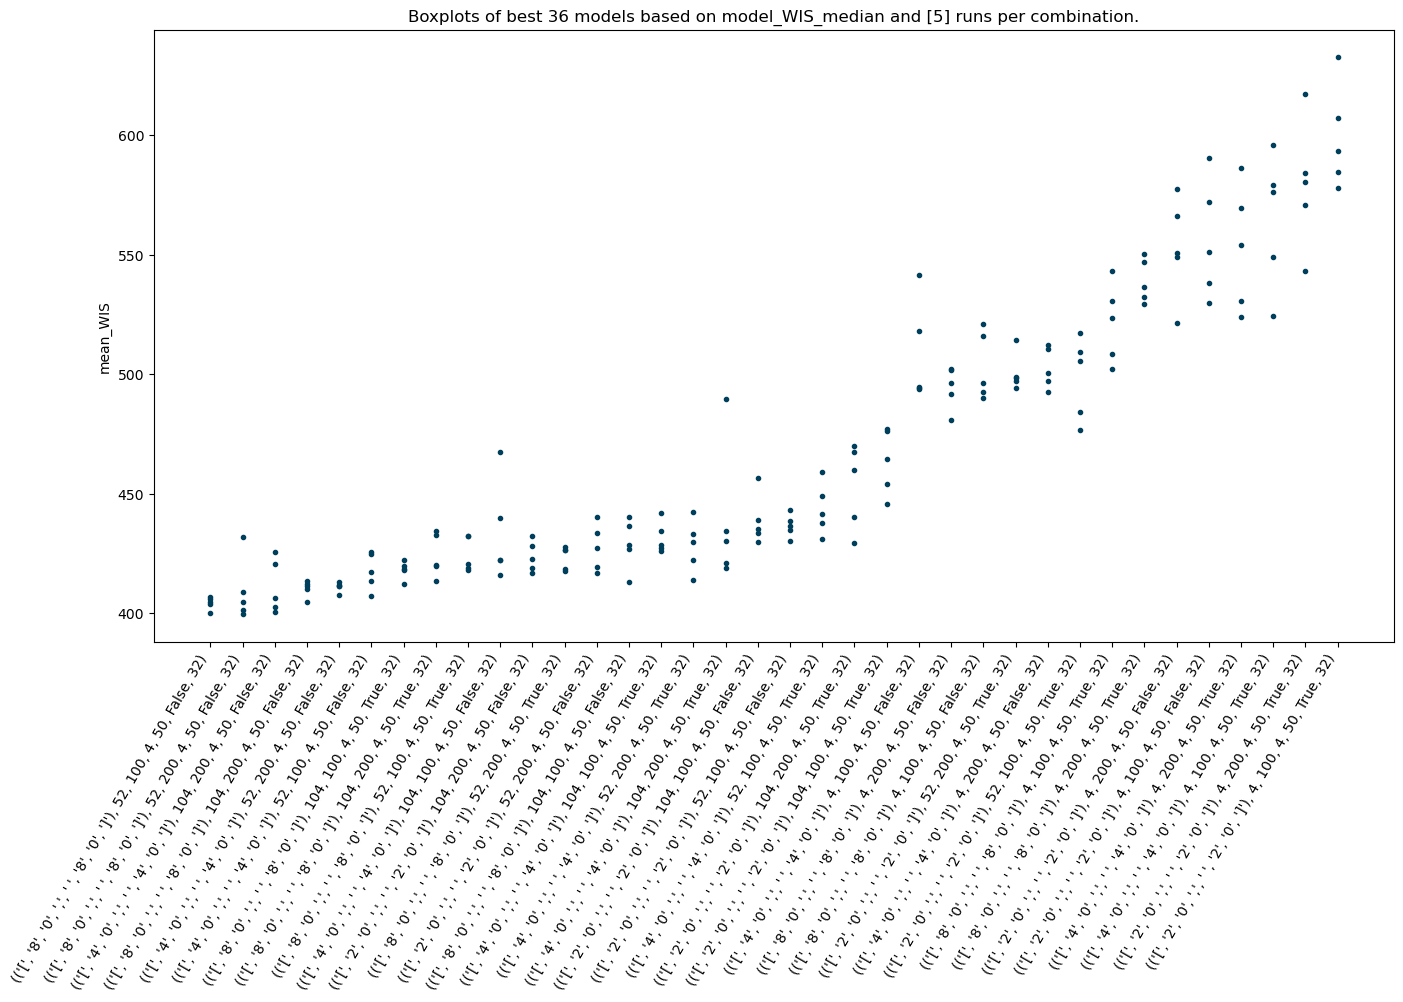

In [10]:

'''
col: "mean_WIS", "time_this_iter_s"
sort_by: "mean_WIS", "time_this_iter_s", "model_WIS_mean", "model_WIS_variance", "model_WIS_sd", "model_WIS_median", "model_time_mean", "model_time_variance", "model_time_sd",\
         "model_time_median"(, "shape") 
plottype: "unordered"(not ordered), "best" or "worst"
'''
plot_model_results_by_hp(configuration, model_results_by_hp, hp_search_space, number_of_plots=40, col="mean_WIS",figsize=(16, 9), overall_df=overall_df, sort_by="model_WIS_median", plottype="best", plot = "scatter")

In [5]:
added_cols = ["model_WIS_mean", "model_WIS_variance", "model_WIS_sd", "model_WIS_median", "model_time_mean", "model_time_variance", "model_time_sd",\
         "model_time_median", "shape"] 
# We can't drop duplicates of num_hidden_dimensions as this column is reported as lists
display(overall_df1.sort_values("model_WIS_mean")[added_cols+[col for col in df1.columns if ("config" in col)]].drop_duplicates().head(20))
display(overall_df2.sort_values("model_WIS_mean")[added_cols+[col for col in df2.columns if ("config" in col)]].drop_duplicates().head(20))

,model_WIS_mean,model_WIS_variance,model_WIS_sd,model_WIS_median,model_time_mean,model_time_variance,model_time_sd,model_time_median,shape,config/batch_normalization,config/batch_size,config/context_length,config/epochs,config/num_batches_per_epoch,config/num_hidden_dimensions,config/prediction_length
478,426.043362,64.334818,8.020899,424.252485,1426.525727,5883.116990,76.701480,1457.143910,5.0,True,64,208,200,60,"([, 1, 8, 0, ,, , 1, 8, 0, ])",4
406,427.192089,22.244859,4.716446,427.018135,1162.568960,152627.849143,390.676144,996.608304,5.0,True,64,208,200,40,"([, 1, 4, 0, ,, , 1, 4, 0, ])",4
430,430.064934,33.151756,5.757756,430.899101,1418.179613,473.413302,21.758063,1421.151007,5.0,True,64,208,200,60,"([, 1, 4, 0, ,, , 1, 4, 0, ])",4
166,431.709009,71.456571,8.453199,432.080348,1007.826535,2906.452493,53.911525,975.154346,5.0,True,64,208,200,40,"([, 1, 8, 0, ,, , 1, 8, 0, ])",4
23,432.264467,52.782291,7.265142,433.384037,1160.790525,159225.106750,399.030208,994.240158,5.0,False,64,208,200,40,"([, 1, 4, 0, ,, , 1, 4, 0, ])",4
418,433.023383,73.269754,8.559775,434.566523,776.143232,2107.806477,45.910854,757.479553,5.0,True,64,208,100,60,"([, 1, 4, 0, ,, , 1, 4, 0, ])",4
47,434.182428,22.788665,4.773747,434.915963,1448.140180,588.997102,24.269262,1457.008542,5.0,False,64,208,200,60,"([, 1, 4, 0, ,, , 1, 4, 0, ])",4
419,435.928843,116.860179,10.810189,432.720859,762.258670,2342.046287,48.394693,748.647352,5.0,False,64,208,100,60,"([, 1, 4, 0, ,, , 1, 4, 0, ])",4
82,437.252015,153.144117,12.375141,438.211362,750.944516,94.499534,9.721087,752.084841,5.0,True,64,208,100,60,"([, 1, 8, 0, ,, , 1, 8, 0, ])",4
383,438.011429,76.054253,8.720909,438.352194,1407.827529,1601.408907,40.017607,1423.203809,5.0,False,64,208,200,60,"([, 1, 8, 0, ,, , 1, 8, 0, ])",4


,model_WIS_mean,model_WIS_variance,model_WIS_sd,model_WIS_median,model_time_mean,model_time_variance,model_time_sd,model_time_median,shape,config/batch_normalization,config/batch_size,config/context_length,config/epochs,config/num_batches_per_epoch,config/num_hidden_dimensions,config/prediction_length
174,401.454014,11.533115,3.396044,401.903489,797.539118,146.532760,12.105072,804.051235,5.0,True,124,104,150,20,"([, 1, 8, 0, ,, , 1, 8, 0, ])",4
354,411.212901,109.608584,10.469412,410.459932,4215.769946,8684.213567,93.189128,4206.602003,5.0,True,124,104,150,120,"([, 1, 4, 0, ,, , 1, 4, 0, ])",4
994,413.376544,38.628155,6.215155,414.432738,439.111507,3951.091780,62.857711,413.874230,5.0,True,124,104,75,20,"([, 1, 4, 0, ,, , 1, 4, 0, ])",4
1014,413.659234,80.714748,8.984139,409.384932,800.027213,2190.652206,46.804404,779.876381,5.0,True,124,104,150,20,"([, 1, 4, 0, ,, , 1, 4, 0, ])",4
874,413.951296,83.399894,9.132354,409.962952,415.773956,1163.068787,34.103794,405.850923,5.0,True,124,104,75,20,"([, 1, 8, 0, ,, , 1, 8, 0, ])",4
1015,414.421569,22.854793,4.780669,414.056270,791.421270,95.341596,9.764302,787.497118,5.0,False,124,104,150,20,"([, 1, 4, 0, ,, , 1, 4, 0, ])",4
475,414.829276,52.805227,7.266720,414.163721,4214.400977,77977.906169,279.245244,4323.494162,5.0,False,124,104,150,120,"([, 1, 8, 0, ,, , 1, 8, 0, ])",4
674,415.465010,146.804553,12.116293,412.644643,1455.266281,355.683009,18.859560,1458.362795,5.0,True,124,104,50,120,"([, 1, 8, 0, ,, , 1, 8, 0, ])",4
1055,415.669758,32.157633,5.670770,415.435050,2047.164781,2549.243782,50.490036,2033.203133,5.0,False,124,104,75,120,"([, 1, 4, 0, ,, , 1, 4, 0, ])",4
234,416.685628,43.049297,6.561196,418.471980,4225.653199,94526.437471,307.451521,4282.362636,5.0,True,124,104,150,120,"([, 1, 8, 0, ,, , 1, 8, 0, ])",4


96
480


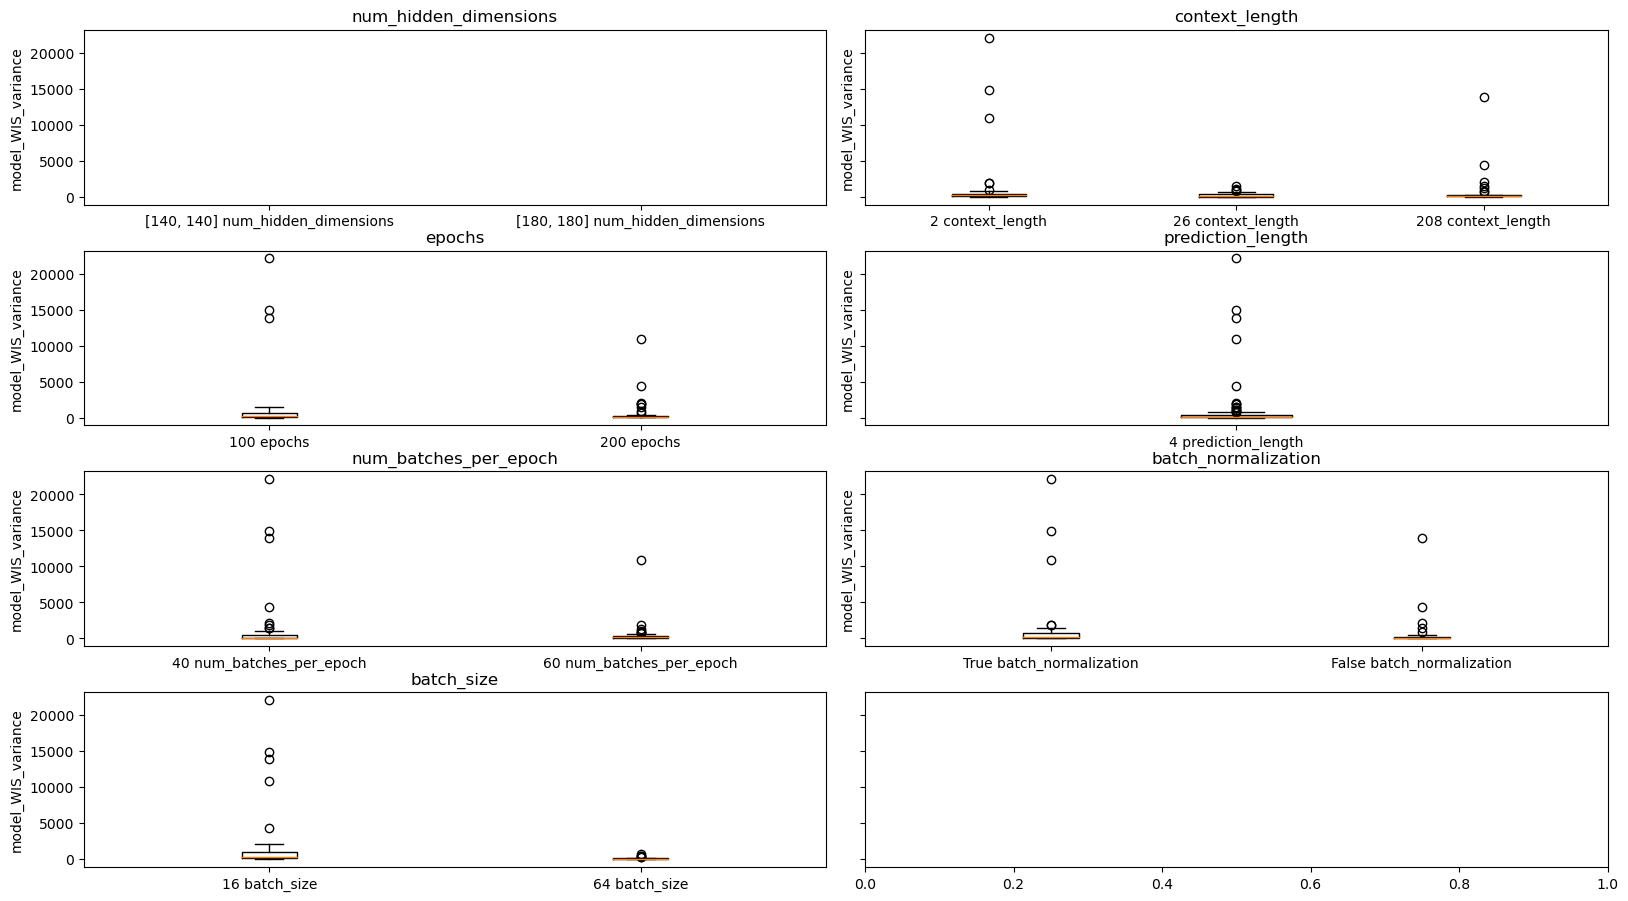

________________


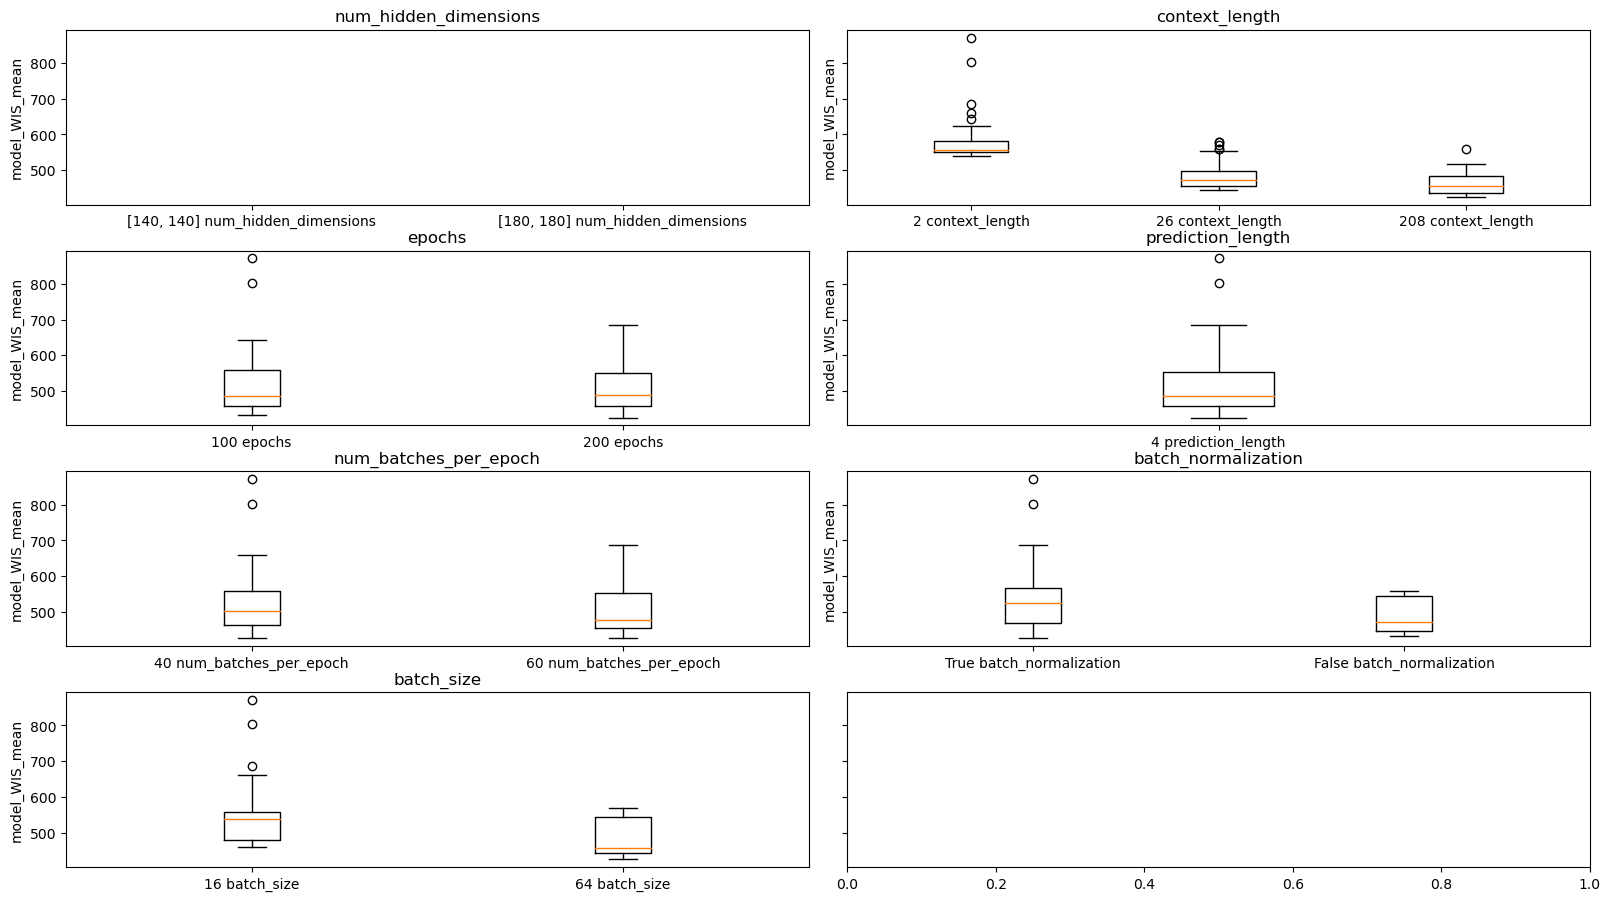

________________


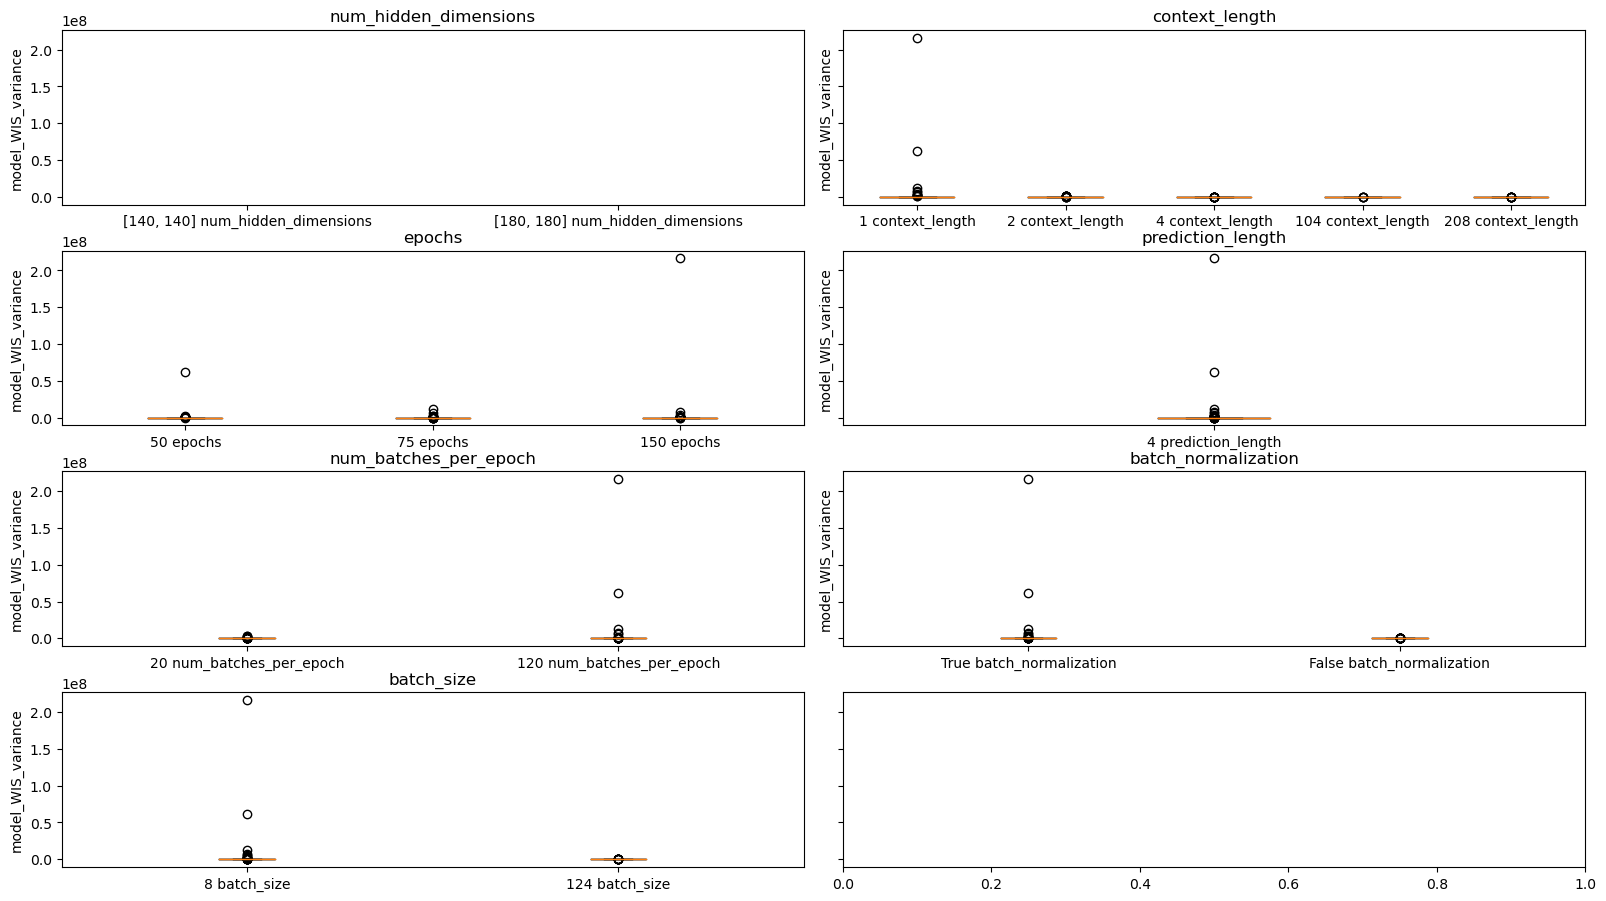

________________


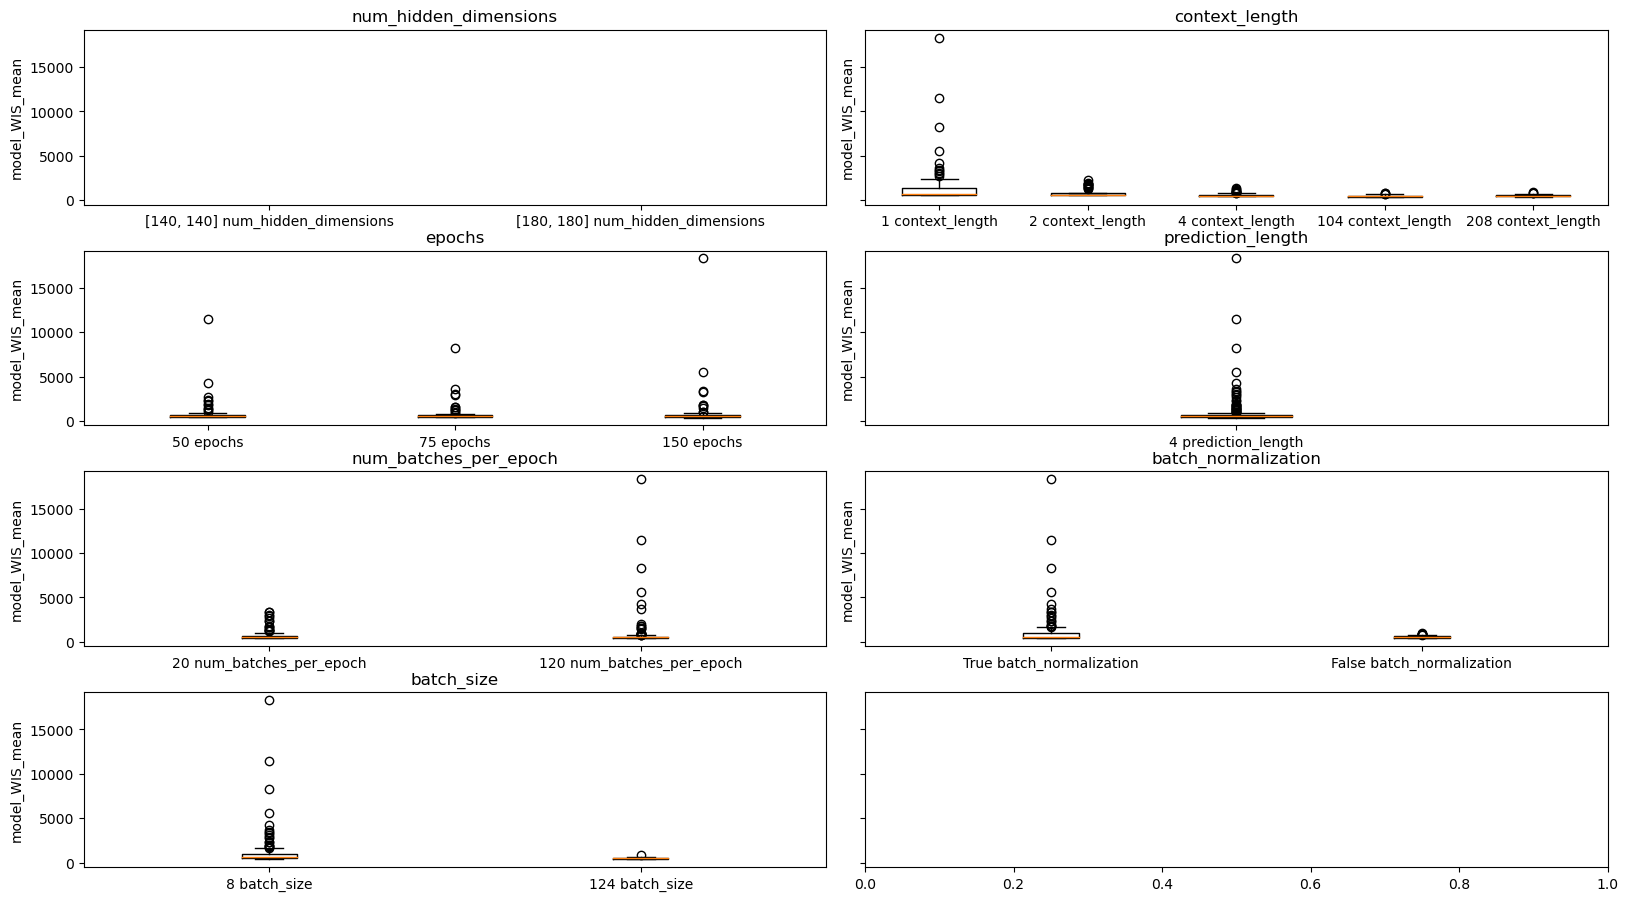

In [13]:
unique_df1 = overall_df1[added_cols+[col for col in df1.columns if ("config" in col)&("cardinality" not in col)]].drop_duplicates()
unique_df2 = overall_df2[added_cols+[col for col in df2.columns if ("config" in col)&("cardinality" not in col)]].drop_duplicates()

def hyperparameter_boxplots1(results_df, hp_search_space, col="mean_WIS"):
    """
    Plot the hyperparameters as boxplots.
    """
    # Create a dict of filtered dfs and x_tick- renamings
    hp_plots = dict()
    for key in hp_search_space.keys():
        if type(hp_search_space[key]) == type(dict()):
            search_grid = hp_search_space[key][list(hp_search_space[key].keys())[0]]
            #search_grid = [tuple(s) if isinstance(s, list) else s for s in search_grid]
            #print(search_grid)
            hp_plots[key] = {"cols" : [f"{i} {key}" for i in search_grid], "df": [results_df.loc[results_df[f'config/{key}'].apply(lambda x: x == tuple(i)), col] if (isinstance(i, list)) else results_df.loc[results_df[f'config/{key}']==i, col] for i in search_grid]} # the if isinstance is necessary for the num_hidden_layers of the FNN
    # plot the boxplots
    nrows = int(len(hp_plots.keys())/2) + int(len(hp_plots.keys())%2)
    fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=(16, 9), sharey=True)
    fig.tight_layout(pad=1.2)
    plotnumber = [0, 0]
    for key in hp_plots.keys():
        if list(hp_plots.keys()).index(key)%2 == 1:
            plotnumber[1] = 1
        else:
            if list(hp_plots.keys()).index(key) > 1:
                plotnumber[0] += 1
            plotnumber[1] = 0
        axs[tuple(plotnumber)].boxplot(hp_plots[key]["df"])
        axs[tuple(plotnumber)].set_title(key)
        axs[tuple(plotnumber)].set_xticks([i for i in range(1, len(hp_plots[key]["df"])+1)], hp_plots[key]["cols"])
        axs[tuple(plotnumber)].set_ylabel(col)
    plt.show()

print(len(unique_df))
print(len(overall_df1))
hyperparameter_boxplots(unique_df1, hp_search_space1, col="model_WIS_variance")
print("________________")
hyperparameter_boxplots(unique_df1, hp_search_space1, col="model_WIS_mean")
print("________________")
hyperparameter_boxplots(unique_df2, hp_search_space2, col="model_WIS_variance")
print("________________")
hyperparameter_boxplots(unique_df2, hp_search_space2, col="model_WIS_mean")

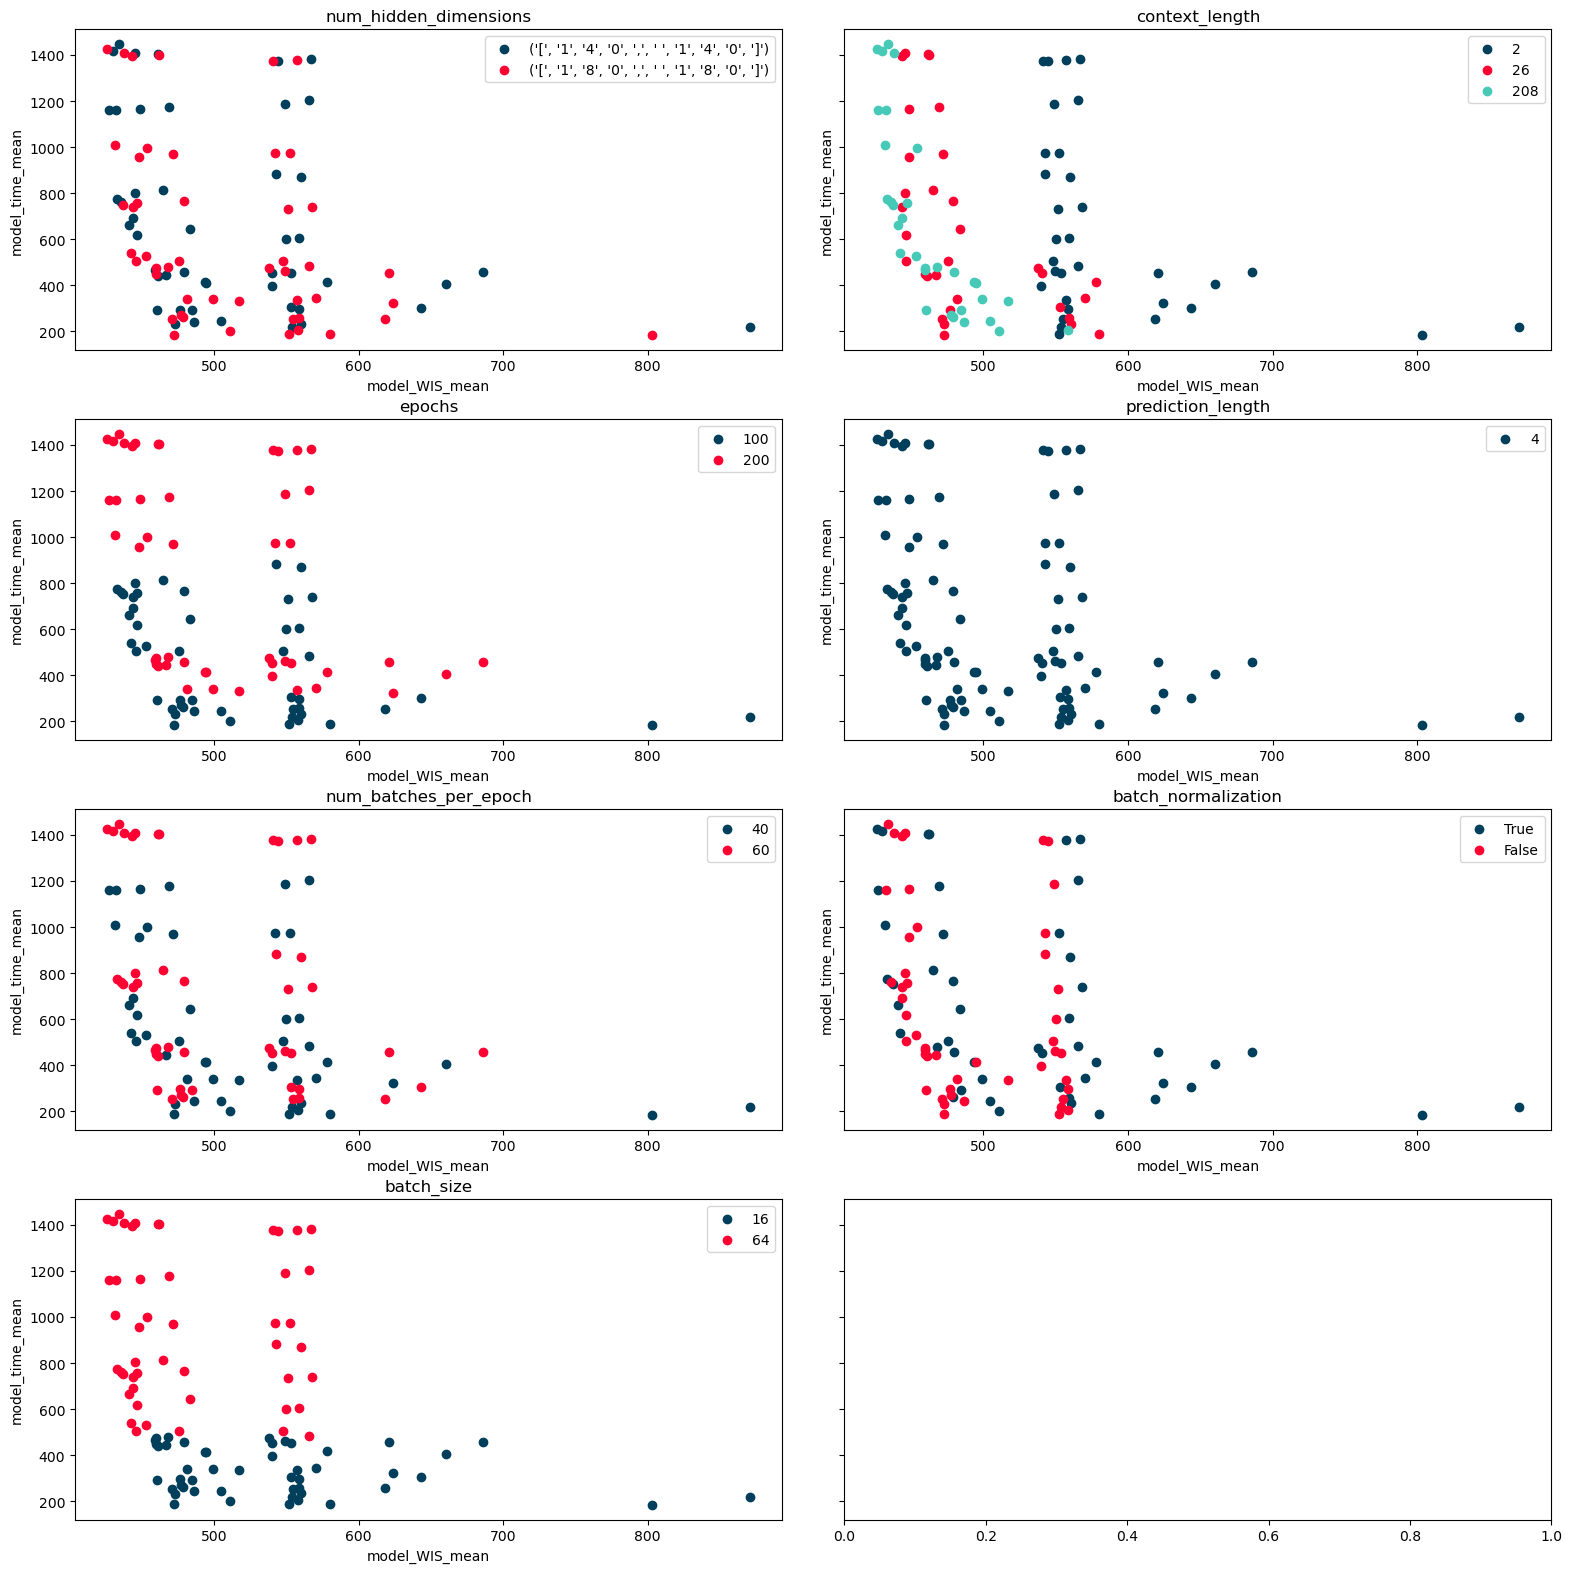

--------


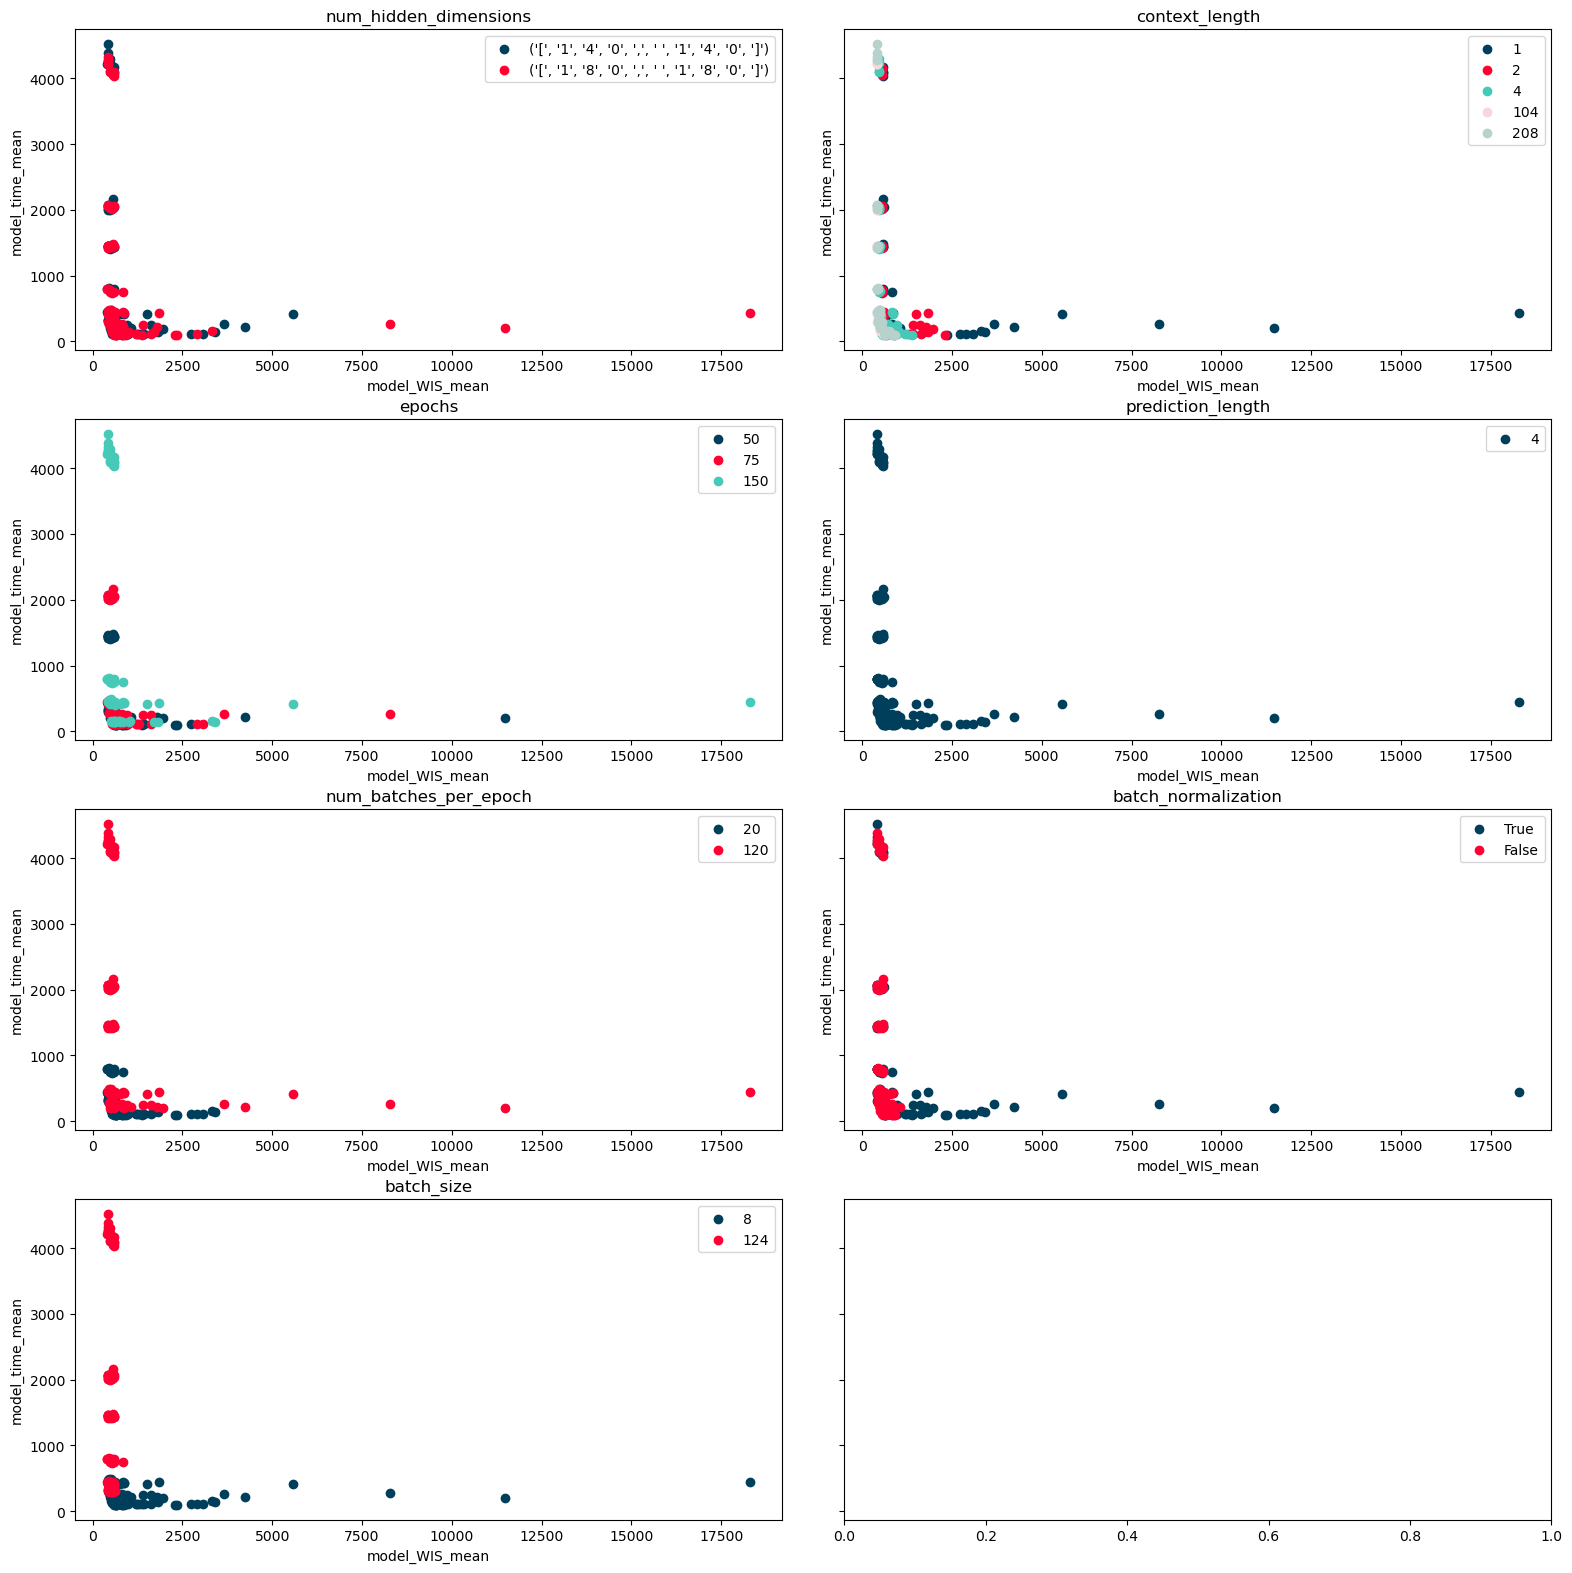

In [12]:
hp_color_plot(configuration, overall_df1, hp_search_space1, )
print("--------")
hp_color_plot(configuration, overall_df2, hp_search_space2, )

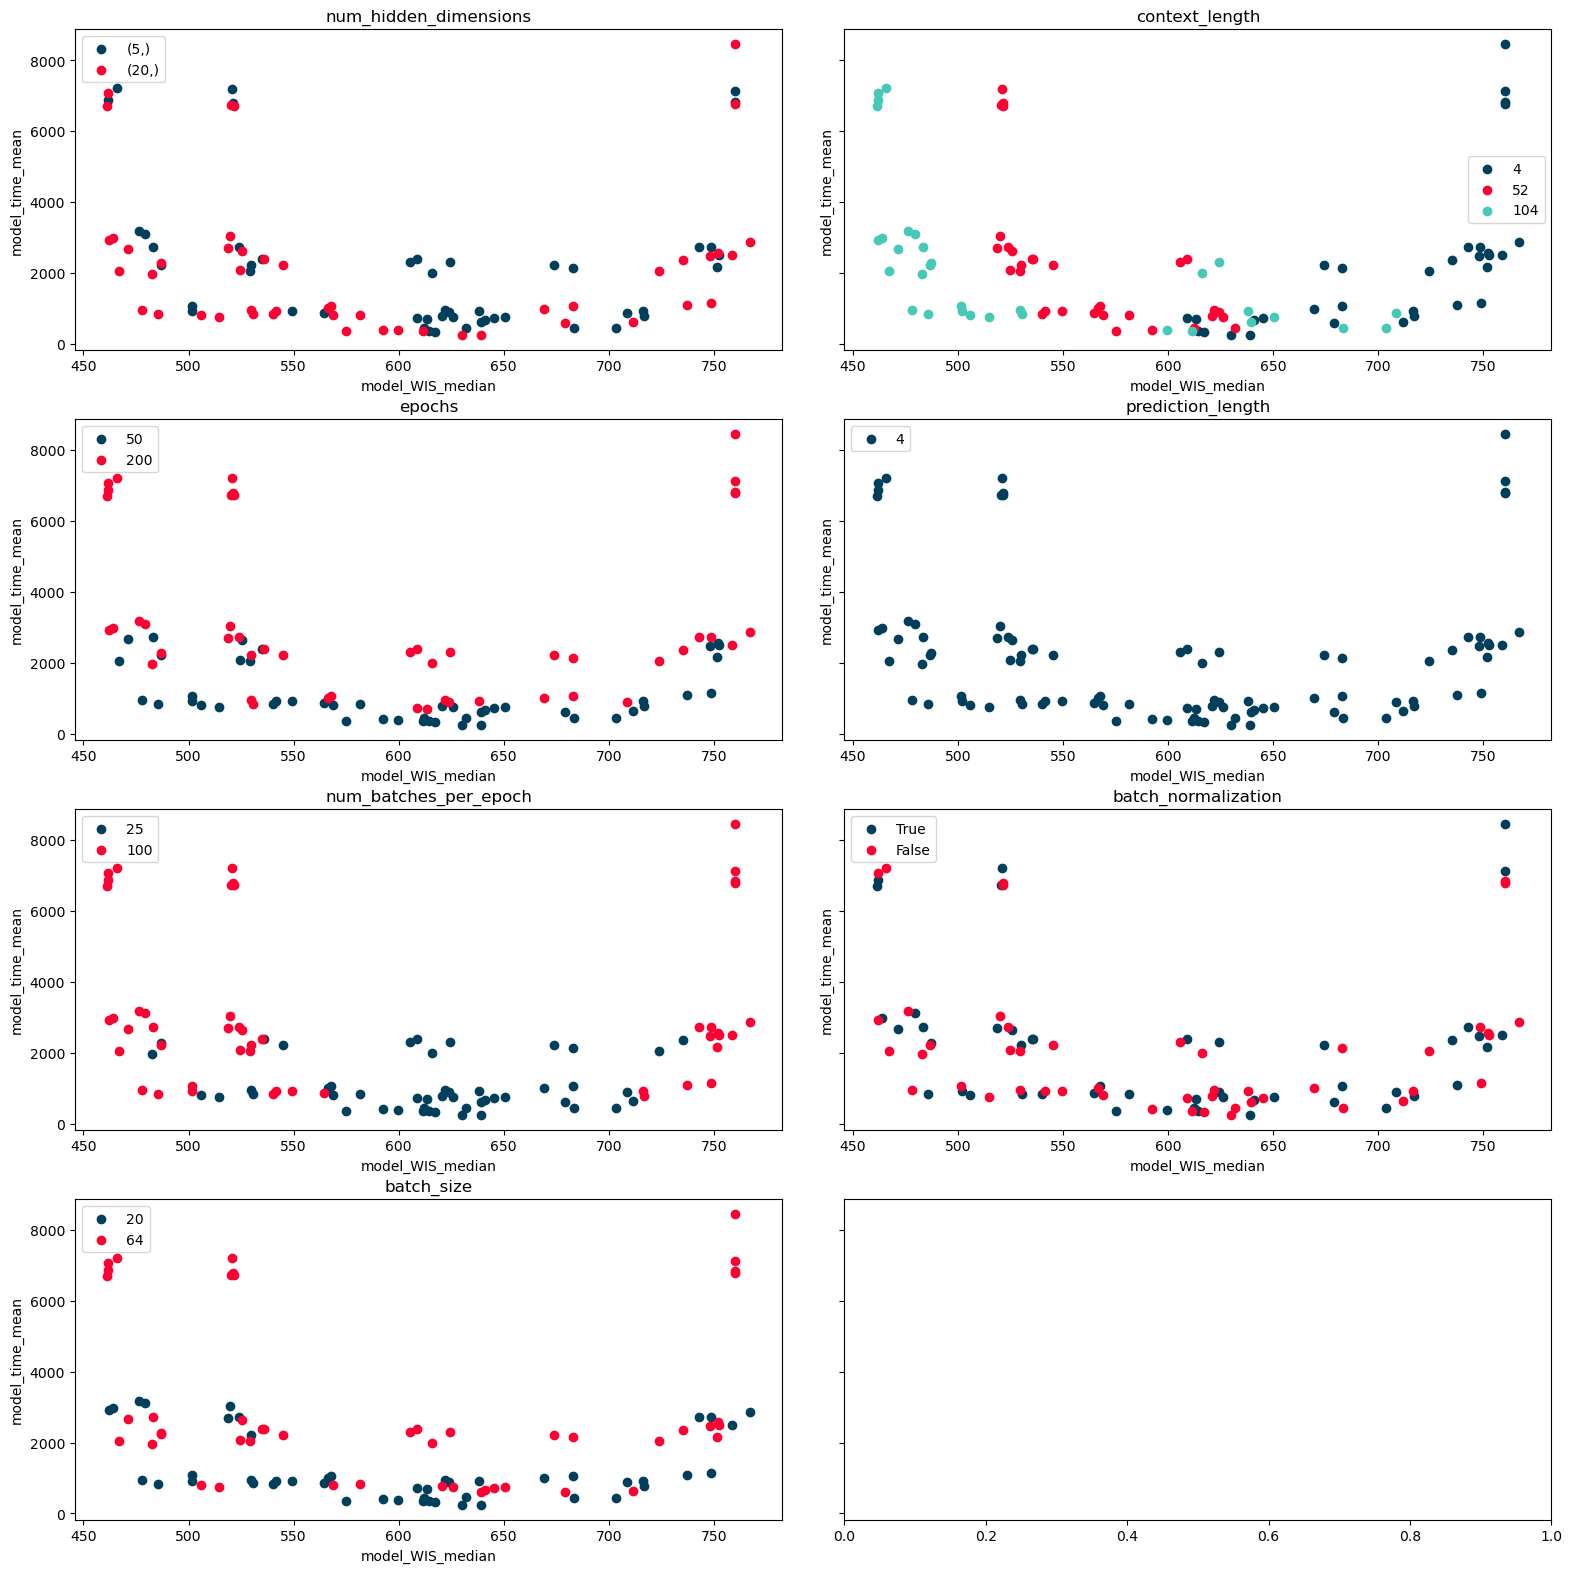

In [15]:
hp_color_plot(configuration, overall_df, hp_search_space, x_axis="model_WIS_median", y_axis="model_time_mean")